**Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

Panduan Project : https://www.dicoding.com/academies/185/tutorials/10179

New York City Daily Temperature From 1869 to 2021
- Proyek ini menghasilkan model untuk memperkirakan **Suhu Maksimum Harian** di *New York City* pada masa mendatang.
- Dataset yang digunakan dalam model ini diambil dari ==> [ysze](https://www.kaggle.com/shaneysze/new-york-city-daily-temperature-18692021)
- Proyek ini dikerjakan sebagai syarat menyelesaikan modul Time Series dalam kelas [Belajar Pengembangan Machine Learning](https://www.dicoding.com/academies/185) di [dicoding](https://www.dicoding.com/)

Nama : Toni Andreas Susanto

Asal : Kota Samarinda, Provinsi Kalimantan Timur

# Import Berbagai Library yang Dibutuhkan

In [85]:
# Import library
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

# Membaca dan Menampilkan Dataframe



In [86]:
df = pd.read_csv('nyc_temp_1869_2021.csv')
df.head()

,Unnamed: 0,MM/DD/YYYY,YEAR,MONTH,DAY,TMAX,TMIN
0,0,1869-01-01,1869,1,1,-17.0,-72.0
1,1,1869-01-02,1869,1,2,-28.0,-61.0
2,2,1869-01-03,1869,1,3,17.0,-28.0
3,3,1869-01-04,1869,1,4,28.0,11.0
4,4,1869-01-05,1869,1,5,61.0,28.0


# Mengecek Dataframe

In [87]:
df.isnull().sum()

Unnamed: 0    0
MM/DD/YYYY    0
YEAR          0
MONTH         0
DAY           0
TMAX          0
TMIN          0
dtype: int64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55634 entries, 0 to 55633
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  55634 non-null  int64  
 1   MM/DD/YYYY  55634 non-null  object 
 2   YEAR        55634 non-null  int64  
 3   MONTH       55634 non-null  int64  
 4   DAY         55634 non-null  int64  
 5   TMAX        55634 non-null  float64
 6   TMIN        55634 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 3.0+ MB


# Menghapus Kolom yang Tidak Diperlukan dan Menganti Nama Kolom

In [89]:
df = df.drop(columns=['Unnamed: 0','YEAR','MONTH','DAY','TMIN'])
df = df.rename(columns={'MM/DD/YYYY': 'Date'})
df

,Date,TMAX
0,1869-01-01,-17.0
1,1869-01-02,-28.0
2,1869-01-03,17.0
3,1869-01-04,28.0
4,1869-01-05,61.0
...,...,...
55629,2021-04-30,217.0
55630,2021-05-01,183.0
55631,2021-05-02,278.0
55632,2021-05-03,189.0


# Mengubah Nilai-Nilai dari Dataframe ke Dalam Tipe Data Numpy Array Menggunakan Atribut Values.

In [90]:
date = df['Date'].values
tmax = df['TMAX'].values

# Membagi Data untuk Training dan Testing.

In [91]:
x_train, x_test, y_train, y_test = train_test_split(date, tmax, train_size=0.8, test_size = 0.2, shuffle = False )

# Melakukan Rescale data

In [92]:
scaler = MinMaxScaler()
y_train_scale = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scale = scaler.fit_transform(y_test.reshape(-1, 1))

In [93]:
n = 20
train_gen = TimeseriesGenerator(y_train_scale, y_train_scale, length=n, batch_size=20)     
test_gen = TimeseriesGenerator(y_test_scale, y_test_scale, length=n, batch_size=1)

# Membangun Arsitektur Model

In [94]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(n, 1)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20, 32)            4352      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


# Implementasi callbacks

In [95]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE telah mencapai < 10%!")
      self.model.stop_training = True
callbacks = myCallback()

# Memlih Optimizer, Loss & Metrics serta Melatih Model

In [97]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])
history = model.fit_generator(train_gen, 
                    epochs=20, 
                    callbacks=[callbacks],
                    validation_data = test_gen, 
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
2225/2225 [==============================] - 64s 28ms/step - loss: 0.0115 - mae: 0.1224 - val_loss: 0.0092 - val_mae: 0.1135
Epoch 2/20
2225/2225 [==============================] - 70s 31ms/step - loss: 0.0108 - mae: 0.1182 - val_loss: 0.0086 - val_mae: 0.1089
Epoch 3/20
2225/2225 [==============================] - 67s 30ms/step - loss: 0.0100 - mae: 0.1138 - val_loss: 0.0081 - val_mae: 0.1055
Epoch 4/20
2225/2225 [==============================] - 43s 19ms/step - loss: 0.0094 - mae: 0.1103 - val_loss: 0.0076 - val_mae: 0.1019
Epoch 5/20
2225/2225 [==============================] - 62s 28ms/step - loss: 0.0088 - mae: 0.1064 - val_loss: 0.0071 - val_mae: 0.0984
Epoch 6/20
2225/2225 [==============================] - 49s 22ms/step - loss: 0.0083 - mae: 0.1030 - val_loss: 0.0068 - val_mae: 0.0957
Epoch 7/20
2225/2225 [==============================] - 42s 19ms/step - loss: 0.0079 - mae: 0.1003 - val_loss: 0.0064 - val_mae: 0.0925
Epoch 8/20
2220/2225 [==========================

# Membuat Plot Loss dan MAE Pada Saat Training dan Testing / Validation

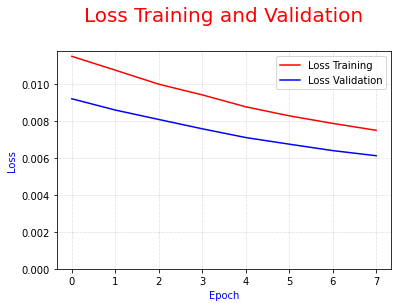

<Figure size 432x288 with 0 Axes>

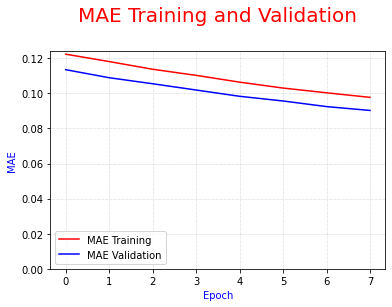

<Figure size 432x288 with 0 Axes>

In [101]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(len(loss))

# Plot Loss Training dan Validasi
plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss Training and Validation', loc='center', pad=30, fontsize=20, color='red')
plt.ylabel('Loss', color='blue')
plt.xlabel('Epoch', color='blue')
plt.legend(loc=0)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()

# Plot MAE Training dan Validasi
plt.plot(epochs, mae, 'r', label='MAE Training')
plt.plot(epochs, val_mae, 'b', label='MAE Validation')
plt.title('MAE Training and Validation', loc='center', pad=30, fontsize=20, color='red')
plt.ylabel('MAE', color='blue')
plt.xlabel('Epoch', color='blue')
plt.legend(loc=0)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()